## Problem description: dimension reduction for turbomachinery design studies

Modern turbomachinery design problems are characterised by high-dimensional design spaces, strongly coupled geometric parameters, and nonlinear performance responses evaluated across multiple operating conditions. Design variables typically encode blade geometry, flow control parameters, and aerodynamic shape descriptors, while quantities of interest may include efficiency, pressure ratio, or loss metrics. Understanding the dominant directions in such design spaces is essential for efficient design exploration, optimisation, and robustness analysis.

The data used in this study originate from a publicly available turbomachinery design dataset introduced by Seshadri et al. (2019). These datasets were specifically constructed to evaluate the effectiveness of subspace-based dimension reduction techniques in the context of realistic turbomachinery design problems. Each dataset consists of a collection of design parameter vectors and associated performance metrics obtained from high-fidelity aerodynamic simulations. The design variables are continuous and moderately high-dimensional, reflecting the complexity of industrial fan design problems.

The central objective considered here is to identify a low-dimensional manifold in the design parameter space that captures the dominant variation in a chosen performance metric. Formally, given a set of design vectors $x_i \in \mathbb{R}^d$ and corresponding scalar responses $f_i \in \mathbb{R}$, we seek a projection matrix $M \in \mathbb{R}^{d \times r}$, with $r \ll d$, such that the response can be accurately approximated as a function of the reduced coordinates
$$
z_i = M^\top x_i.
$$
This representation assumes that the performance metric depends primarily on a small number of latent design directions, even though it is originally expressed in a high-dimensional parameterisation.

To identify such a subspace, we employ a goal-oriented dimension reduction approach in which the projection matrix $M$ is learned by directly minimising the approximation error of a surrogate model defined on the reduced space. A nonlinear surrogate is used to model the relationship between the reduced coordinates and the performance metric, allowing for complex but smooth dependencies. The projection matrix is constrained to lie on the Grassmann manifold to ensure orthonormality and to avoid degenerate solutions.

In [ ]:
import numpy as np
import torch

from manifold_learning.features import RFFFeatures
from manifold_learning.grassmann import stochastic_grassmann_ridge


X = torch.tensor(np.loadtxt("design_parameters.dat"), dtype=torch.float32)

N, d = X.shape

r = 1

f = torch.tensor(np.loadtxt("non_dimensionalized_efficiency.dat"), dtype=torch.float32)

m=256 

feature_model = RFFFeatures(r=r, m=m, sigma=1.0, device=X.device, dtype=X.dtype) 

M_star, alpha_star = stochastic_grassmann_ridge( X=X, f=f, r=r, feature_model=feature_model, lam=1e-2, eta=5e-2, batch_size=256, steps=3000, tol=1e-7, patience=30, seed=0, ) 


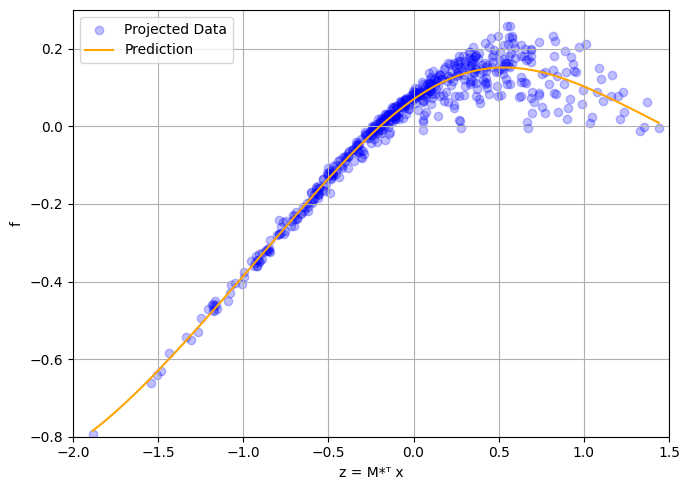

In [2]:
import matplotlib.pyplot as plt

DIGILAB_INDIGO = "#224159"

# 1D coordinate (since r=1)
z = (X @ M_star).squeeze()
f_np = f.squeeze()

z_min = z.min().item()
z_max = z.max().item()

z_grid = torch.linspace(z_min, z_max, 300, device=X.device).unsqueeze(1)

Phi_grid = feature_model.phi(z_grid)   # (300, p)
f_pred = Phi_grid @ alpha_star         # (300,)

# Detrended residual
Phi = feature_model.phi(X @ M_star)          # (N, p)
f_hat = (Phi @ alpha_star).squeeze()  # (N,)
resid = f.squeeze() - f_hat

plt.figure(figsize=(7,5))

plt.scatter(
    z.cpu().numpy(),
    f.cpu().numpy(),
    alpha=0.25,
    color="blue",
    label="Projected Data"
)

plt.plot(
    z_grid.squeeze().cpu().numpy(),
    f_pred.cpu().numpy(),
    color="orange",
    label="Prediction"
)
plt.xlim([-2.0, 1.5])
plt.ylim([-0.8, 0.3])
plt.xlabel("z = M*ᵀ x")
plt.ylabel("f")
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()